## Deep Learning Classification task

In this notebook, my goal is to predict the accuracy of the Score category assigned to each video game review by using the review text with different NLP analysis tools. These techniques include base models such as Naive Bayes and Logistic Regression with TF-IDF, as well as BERT embeddings, Random Forest, and deep learning approaches like Fine-Tuned DistilBERT and LSTM-based RNN. The goal is to identify which model most accurately aligns review content with the assigned score, and if deep learning models provide a significant advantage over simpler classifier models. I expect the more sophisticated models to accurately predict whether a score is bad, medium, or high. Since the score is a numerical value and this is a classification task, I will divide the game reviews into different categories, using my experience in video game reviews to group them logically.

### Data exploration

Please uncomment the following code if you like to access the file directly in Colab from the Cloud.

In [3]:
# import gdown
# import pandas as pd

# # Updated file ID
# file_id = "1hCdsIfcWrWZtta4CJtMasvNRf9HE7GYk"

# # New download URL
# download_url = f"https://drive.google.com/uc?id={file_id}"

# output_file = 'downloaded_file.csv'
# gdown.download(download_url, output_file, quiet=False)

# # Load the new CSV into the DataFrame
# df = pd.read_csv(output_file)


Please use the following if you like to access the csv file locally, and change the path accordingly.

In [4]:
import pandas as pd

file_path = "/teamspace/studios/this_studio/Project/Final files updated/gamespot_reviews_complete.csv"

df = pd.read_csv(file_path)



In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10495 entries, 0 to 10494
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Title   10495 non-null  object 
 1   Score   10495 non-null  float64
 2   Link    10495 non-null  object 
 3   Review  10495 non-null  object 
dtypes: float64(1), object(3)
memory usage: 328.1+ KB


In [6]:
df.head()

,Title,Score,Link,Review
0,Super Mario Party Jamboree Review - This Party...,6.0,https://www.gamespot.com/reviews/super-mario-p...,Nintendo's party loses a little luster in its ...
1,Backyard Baseball '97 Review - Hit Parade,8.0,https://www.gamespot.com/reviews/backyard-base...,The classic children's sports gaming franchise...
2,Dragon Ball: Sparking Zero Review - Final Flas...,6.0,https://www.gamespot.com/reviews/dragon-ball-s...,The frenetic fighting Dragon Ball fans expect ...
3,Diablo 4: Vessel Of Hatred Review - Piercing T...,8.0,https://www.gamespot.com/reviews/diablo-4-vess...,The Vessel of Hatred expansion meaningfully ex...
4,Silent Hill 2 Remake Review - Born From A Wish,9.0,https://www.gamespot.com/reviews/silent-hill-2...,Remaking one of the most revered horror games ...


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

First, I am checking the different Score values and noticing that the ranges are very unbalanced.

In [8]:
# Round the scores to full integers
df['Rounded_Score'] = df['Score'].round().astype(int)

# Get the count of each unique rounded score
rounded_score_counts = df['Rounded_Score'].value_counts().sort_index()

# Display the counts for each unique rounded score
rounded_score_counts


Rounded_Score
1        8
2      135
3      201
4      760
5      837
6     2123
7     2252
8     3317
9      793
10      69
Name: count, dtype: int64

Since this is a classification task, I grouped the scores into different ranges to naturally balance the data. Additionally, I used the median to ensure balanced sampling across the different categories.

In [9]:
import pandas as pd
from sklearn.utils import resample

# I reclassify scores based on the new ranges
def classify_score(score):
    if 1 <= score <= 5:
        return 'bad'
    elif 6 <= score <= 7:
        return 'medium'
    elif score >= 8:
        return 'good'

# Apply the classification
df['Score_Category'] = df['Rounded_Score'].apply(classify_score)

# Get counts for each category
category_counts = df['Score_Category'].value_counts()

# Calculate a balanced target count, the median of the counts
target_count = int(category_counts.median())

# Resample each category to the target count
balanced_df = pd.concat([
    resample(df[df['Score_Category'] == 'bad'], n_samples=target_count, replace=True, random_state=42),
    resample(df[df['Score_Category'] == 'medium'], n_samples=target_count, replace=True, random_state=42),
    resample(df[df['Score_Category'] == 'good'], n_samples=target_count, replace=True, random_state=42)
])

# Display the counts in the balanced dataset
balanced_category_counts = balanced_df['Score_Category'].value_counts()
balanced_category_counts




Score_Category
bad       4179
medium    4179
good      4179
Name: count, dtype: int64

In [10]:
df.head()

,Title,Score,Link,Review,Rounded_Score,Score_Category
0,Super Mario Party Jamboree Review - This Party...,6.0,https://www.gamespot.com/reviews/super-mario-p...,Nintendo's party loses a little luster in its ...,6,medium
1,Backyard Baseball '97 Review - Hit Parade,8.0,https://www.gamespot.com/reviews/backyard-base...,The classic children's sports gaming franchise...,8,good
2,Dragon Ball: Sparking Zero Review - Final Flas...,6.0,https://www.gamespot.com/reviews/dragon-ball-s...,The frenetic fighting Dragon Ball fans expect ...,6,medium
3,Diablo 4: Vessel Of Hatred Review - Piercing T...,8.0,https://www.gamespot.com/reviews/diablo-4-vess...,The Vessel of Hatred expansion meaningfully ex...,8,good
4,Silent Hill 2 Remake Review - Born From A Wish,9.0,https://www.gamespot.com/reviews/silent-hill-2...,Remaking one of the most revered horror games ...,9,good


### Models
- Applying different models and comparing them
- Predicting Score Category Using 

#### 1. Naive Bayes and TF-IDF Vectorization

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Score_Category'], test_size=0.2, random_state=42)

# Vectorize the text data
tfidf = TfidfVectorizer(max_features=5000)  # Limiting to top 5000 features for efficiency
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train a Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train_tfidf, y_train)

# Make predictions and evaluate
y_pred = classifier.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         bad       1.00      0.03      0.05       386
        good       0.67      0.62      0.65       837
      medium       0.50      0.76      0.61       876

    accuracy                           0.57      2099
   macro avg       0.73      0.47      0.43      2099
weighted avg       0.66      0.57      0.52      2099



#### 2. Logistic Regression with TF-IDF

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Score_Category'], test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)  # Limit features for efficiency
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# logistic Regression Classifier
classifier = LogisticRegression(max_iter=1000)  # Increased iterations for convergence
classifier.fit(X_train_tfidf, y_train)

#  predictions and evaluate
y_pred = classifier.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bad       0.85      0.46      0.60       386
        good       0.76      0.78      0.77       837
      medium       0.65      0.76      0.70       876

    accuracy                           0.71      2099
   macro avg       0.75      0.67      0.69      2099
weighted avg       0.73      0.71      0.71      2099



In [13]:
#!pip install sentence-transformers


#### 3. BERT Embeddings with Logistic Regression

In [14]:
# Filter out None or empty reviews
df = df[df['Review'].notna() & df['Review'].str.strip() != '']

# Generate BERT Embeddings
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')  # A lighter BERT variant
X = model.encode(df['Review'].tolist())  # Converts each review to an embedding
y = df['Score_Category']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Train a Classifier on the BERT embeddings
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

#  Make Predictions and Evaluate
y_pred = classifier.predict(X_test)

# classification report and accuracy
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-10-29 08:25:59.602632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 08:25:59.659366: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 08:25:59.672181: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 08:25:59.782576: I tensorflow/core/platf

Classification Report:
               precision    recall  f1-score   support

         bad       0.54      0.39      0.45       386
        good       0.63      0.66      0.64       837
      medium       0.55      0.59      0.57       876

    accuracy                           0.58      2099
   macro avg       0.57      0.55      0.56      2099
weighted avg       0.58      0.58      0.58      2099

Accuracy: 0.5807527393997142


#### 4. Advanced BERT Embeddings and Support Vector Machine (SVM)

In [15]:
from sentence_transformers import SentenceTransformer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Using a more powerful BERT model for embeddings
model = SentenceTransformer('all-mpnet-base-v2')
X = model.encode(df['Review'].tolist())
y = df['Score_Category']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a more complex Classifier on the BERT embeddings (e.g., SVM)
classifier = SVC(kernel='linear', C=1)  # Linear SVM with regularization parameter
classifier.fit(X_train, y_train)

#  Predictions and Evaluate
y_pred = classifier.predict(X_test)

# classification report and accuracy
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

         bad       0.66      0.40      0.50       386
        good       0.69      0.74      0.71       837
      medium       0.58      0.64      0.61       876

    accuracy                           0.64      2099
   macro avg       0.64      0.59      0.61      2099
weighted avg       0.64      0.64      0.63      2099

Accuracy: 0.6369699857074798


#### 5. BERT Embeddings and Random Forest Classifier

In [16]:
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Generate embeddings using a more powerful model
model = SentenceTransformer('all-mpnet-base-v2')
X = model.encode(df['Review'].tolist())
y = df['Score_Category']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier on the embeddings
classifier = RandomForestClassifier(n_estimators=200, random_state=42)
classifier.fit(X_train, y_train)

# Make Predictions and Evaluate
y_pred = classifier.predict(X_test)

# classification report and accuracy
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

         bad       0.95      0.19      0.31       386
        good       0.67      0.71      0.69       837
      medium       0.57      0.73      0.64       876

    accuracy                           0.62      2099
   macro avg       0.73      0.54      0.55      2099
weighted avg       0.68      0.62      0.60      2099

Accuracy: 0.6236303001429252


#### 6. Fine-Tuning DistilBERT for Score Category Prediction

In [17]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from datasets import Dataset


# Encode labels
label_encoder = LabelEncoder()
df['Score_Category_Encoded'] = label_encoder.fit_transform(df['Score_Category'])

# Split into train and test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Review'], df['Score_Category_Encoded'], test_size=0.2, random_state=42
)

# Load tokenizer and tokenize the texts
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128)

# Create torch dataset
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ReviewDataset(train_encodings, train_labels.tolist())
test_dataset = ReviewDataset(test_encodings, test_labels.tolist())

# Load DistilBERT model and fine-tune
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

training_args = TrainingArguments(
    output_dir='./results',          
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=test_dataset             
)

#  Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

# Make predictions and convert to labels
predictions = trainer.predict(test_dataset).predictions
predicted_labels = predictions.argmax(axis=1)
predicted_labels_decoded = label_encoder.inverse_transform(predicted_labels)
test_labels_decoded = label_encoder.inverse_transform(test_labels)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(test_labels_decoded, predicted_labels_decoded))



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.786000,0.661932
2,0.545800,0.636597
3,0.397000,0.677516
4,0.284900,0.725817


Evaluation Results: {'eval_loss': 0.7258166074752808, 'eval_runtime': 3.8494, 'eval_samples_per_second': 545.273, 'eval_steps_per_second': 34.291, 'epoch': 4.0}
              precision    recall  f1-score   support

         bad       0.70      0.62      0.66       386
        good       0.82      0.80      0.81       837
      medium       0.69      0.74      0.72       876

    accuracy                           0.74      2099
   macro avg       0.74      0.72      0.73      2099
weighted avg       0.74      0.74      0.74      2099



#### 7. Using an LSTM-Based Recurrent Neural Network (RNN)

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, SpatialDropout1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['Review'])
X = tokenizer.texts_to_sequences(df['Review'])
X = pad_sequences(X, maxlen=200)

# Encode labels for neural network
y = pd.get_dummies(df['Score_Category']).values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define RNN Model
rnn_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=200),
    SpatialDropout1D(0.2),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train RNN Model
rnn_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

# Evaluate RNN Model
rnn_pred = np.argmax(rnn_model.predict(X_test), axis=1)
y_test_labels = np.argmax(y_test, axis=1)
print("\nRNN Model Classification Report:\n", classification_report(y_test_labels, rnn_pred))
print("RNN Model Accuracy:", accuracy_score(y_test_labels, rnn_pred))


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5


2024-10-29 08:39:42.367393: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19012 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:35:00.0, compute capability: 8.9


105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step - accuracy: 0.4174 - loss: 1.0499 - val_accuracy: 0.5399 - val_loss: 0.9082
Epoch 2/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 170ms/step - accuracy: 0.5899 - loss: 0.8584 - val_accuracy: 0.5923 - val_loss: 0.8388
Epoch 3/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 168ms/step - accuracy: 0.6622 - loss: 0.7286 - val_accuracy: 0.5821 - val_loss: 0.8466
Epoch 4/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 170ms/step - accuracy: 0.7186 - loss: 0.6506 - val_accuracy: 0.6571 - val_loss: 0.8320
Epoch 5/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 170ms/step - accuracy: 0.7816 - loss: 0.5411 - val_accuracy: 0.6232 - val_loss: 0.9332
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step

RNN Model Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.39      0.51       386
           1       0.77      0.61      0.68       837
           2       0.57      0.79      0.66       876

    accuracy                           0.65      2099
   macro avg 

### Visualizing results and comparing accuracy

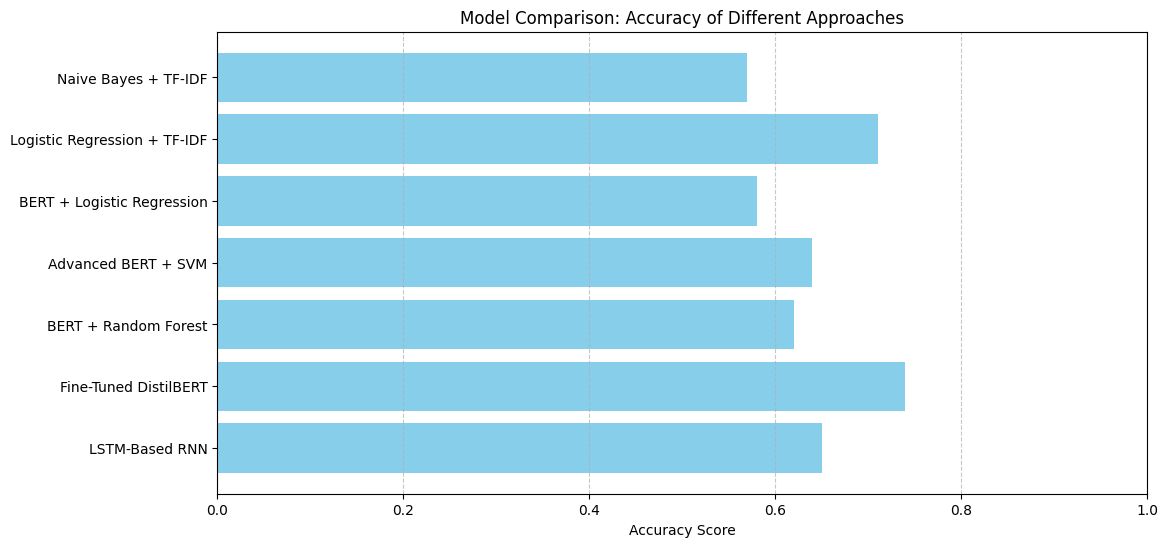

,Model,Accuracy Score
0,Naive Bayes + TF-IDF,56%
1,Logistic Regression + TF-IDF,71%
2,BERT + Logistic Regression,57%
3,Advanced BERT + SVM,64%
4,BERT + Random Forest,62%
5,Fine-Tuned DistilBERT,74%
6,LSTM-Based RNN,65%


In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Define model names and accuracy scores
model_names = [
    'Naive Bayes + TF-IDF', 'Logistic Regression + TF-IDF', 'BERT + Logistic Regression',
    'Advanced BERT + SVM', 'BERT + Random Forest', 'Fine-Tuned DistilBERT', 'LSTM-Based RNN'
]
accuracy_scores = [0.57, 0.71, 0.58, 0.64, 0.62, 0.74, 0.65]

# Create a bar chart for accuracy comparison
plt.figure(figsize=(12, 6))
plt.barh(model_names, accuracy_scores, color='skyblue')
plt.xlabel('Accuracy Score')
plt.title('Model Comparison: Accuracy of Different Approaches')
plt.gca().invert_yaxis()  # Highest accuracy at the top
plt.xlim(0, 1)  # Accuracy as a fraction
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Display accuracy values below the chart as a table with whole numbers for percentages
accuracy_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy Score': [f'{int(score * 100)}%' for score in accuracy_scores]  # Convert to integer percentage
})
accuracy_df



Logistic Regression with TF-IDF and Fine-Tuned DistilBERT perform the best, each achieving over 70% accuracy. I expected the overall score to be higher given there are only three categories. This may be due to the difficulty of grouping review categories, as a score of 5, for example, is technically still a negative review. Additionally, review scores assigned by reviewers are subjective and may not always align with the review content. It’s interesting to note that while fine-tuned deep learning models perform well, some base models nearly match their accuracy, suggesting that multiple approaches can effectively predict review scores. Although a larger sample size could improve scores, I have already used all available data from this source.